# Car Price Analysis

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
from pathlib import Path
import statsmodels.formula.api as smf

# Main Parameters

In [54]:
DATA_FOLDER = Path("data")
RAW_FILE = DATA_FOLDER / "raw_data.csv"
TRAINING_FILE = DATA_FOLDER / "training_data.csv"
TEST_FILE = DATA_FOLDER / "test_data.csv"
OUTPUT_FOLDER = Path("output")
TEST_SET_PERCENTAGE = .1
CREATE_NEW_DATA_SPLITS = False

# Read Data

In [55]:
raw_data_df = pd.read_csv(RAW_FILE,index_col='Car ID').convert_dtypes()
print(raw_data_df.shape)
raw_data_df.head()

(2500, 9)


,Brand,Year,Engine Size,Fuel Type,Transmission,Mileage,Condition,Price,Model
Car ID,,,,,,,,,
1,Tesla,2016,2.3,Petrol,Manual,114832,New,26613.92,Model X
2,BMW,2018,4.4,Electric,Manual,143190,Used,14679.61,5 Series
3,Audi,2013,4.5,Electric,Manual,181601,New,44402.61,A4
4,Tesla,2011,4.1,Diesel,Automatic,68682,New,86374.33,Model Y
5,Ford,2009,2.6,Diesel,Manual,223009,Like New,73577.1,Mustang


In [56]:
# ['Car ID', 'Brand', 'Year', 'Engine Size', 'Fuel Type', 'Transmission',
#        'Mileage', 'Condition', 'Price', 'Model']

# EDA

In [57]:
# Make a copy so that we don't accidentally modify the original data
data_df = raw_data_df.copy()

In [58]:
CATEGORICAL_VARS = ['Brand', 'Fuel Type', 'Transmission', 'Condition', 'Model']
NUMERIC_VARS = ['Year', 'Engine Size', 'Mileage', 'Price']
X_VARS = CATEGORICAL_VARS + ['Year', 'Engine Size', 'Mileage']
Y_VAR = 'Price'

## General

In [59]:
number_of_data_points = data_df.shape[0]
print(f"Number of data points: {number_of_data_points}")

Number of data points: 2500


In [60]:
n = number_of_data_points # We will need this later

## Distributions

### Categorical

In [61]:
data_df[CATEGORICAL_VARS].describe()

,Brand,Fuel Type,Transmission,Condition,Model
count,2500,2500,2500,2500,2500
unique,7,4,2,3,28
top,Toyota,Diesel,Manual,Used,Fiesta
freq,374,655,1308,855,103


Number of unique values: 7
Average number of data points per value: 357.14
Value Counts:


Brand
Toyota      374
Audi        368
BMW         358
Mercedes    353
Honda       352
Tesla       348
Ford        347
Name: count, dtype: Int64

Number of unique values: 4
Average number of data points per value: 625.00
Value Counts:


Fuel Type
Diesel      655
Petrol      630
Electric    614
Hybrid      601
Name: count, dtype: Int64

Number of unique values: 2
Average number of data points per value: 1250.00
Value Counts:


Transmission
Manual       1308
Automatic    1192
Name: count, dtype: Int64

Number of unique values: 3
Average number of data points per value: 833.33
Value Counts:


Condition
Used        855
Like New    836
New         809
Name: count, dtype: Int64

Number of unique values: 28
Average number of data points per value: 89.29
Value Counts:


Model
Fiesta      103
Corolla     103
A3           98
A4           96
CR-V         95
Q7           95
5 Series     93
Model X      93
Prius        93
3 Series     93
X3           92
GLA          92
C-Class      92
Camry        90
Fit          89
E-Class      89
Model Y      89
RAV4         88
Accord       88
Model 3      87
Explorer     86
Focus        81
GLC          80
Civic        80
X5           80
Model S      79
Q5           79
Mustang      77
Name: count, dtype: Int64

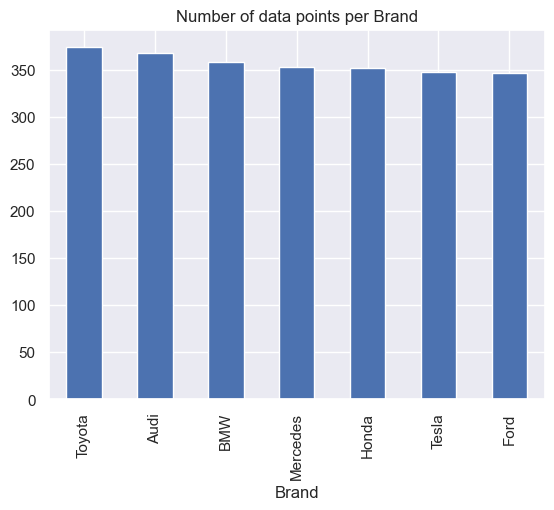

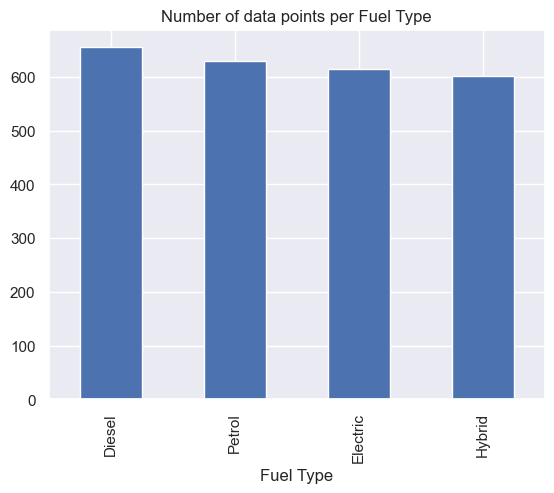

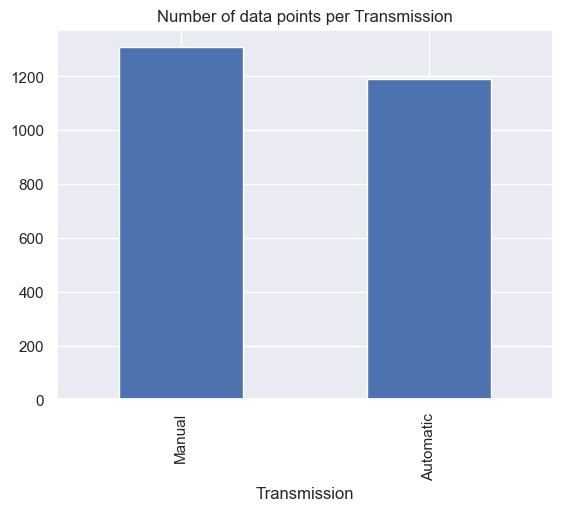

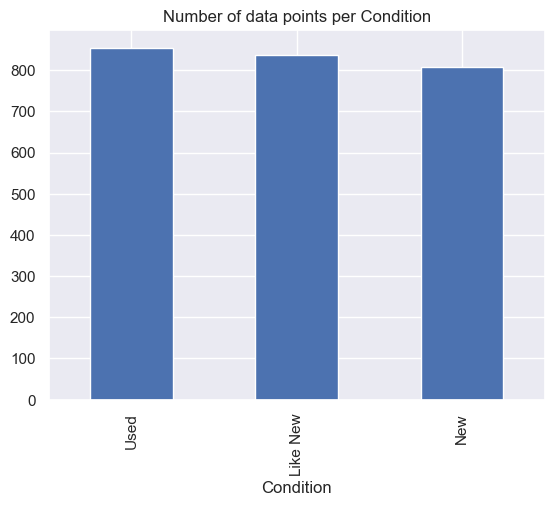

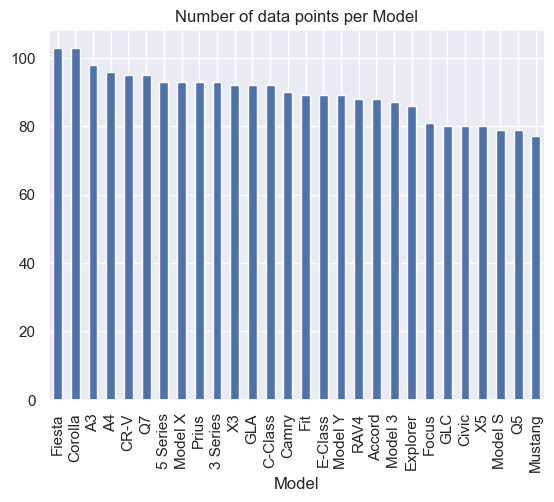

In [62]:
for var in CATEGORICAL_VARS:
    # print(f'Analyzing variable "{var}" ')
    data = data_df[var]
    value_counts = data.value_counts()
    unique_values = value_counts.shape[0]
    print(f'Number of unique values: {unique_values}')
    print(f'Average number of data points per value: {value_counts.mean():.2f}')
    print(f'Value Counts:')
    display(value_counts)
    fig, ax = plt.subplots()
    value_counts.plot(kind='bar', ax=ax, title=f'Number of data points per {var}')


### Numerical

In [63]:
data_df[NUMERIC_VARS].describe()

,Year,Engine Size,Mileage,Price
count,2500.0,2500.0,2500.0,2500.0
mean,2011.6268,3.46524,149749.8448,52638.022532
std,6.9917,1.432053,87919.952034,27295.833455
min,2000.0,1.0,15.0,5011.27
25%,2005.0,2.2,71831.5,28908.485
50%,2012.0,3.4,149085.0,53485.24
75%,2018.0,4.7,225990.5,75838.5325
max,2023.0,6.0,299967.0,99982.59


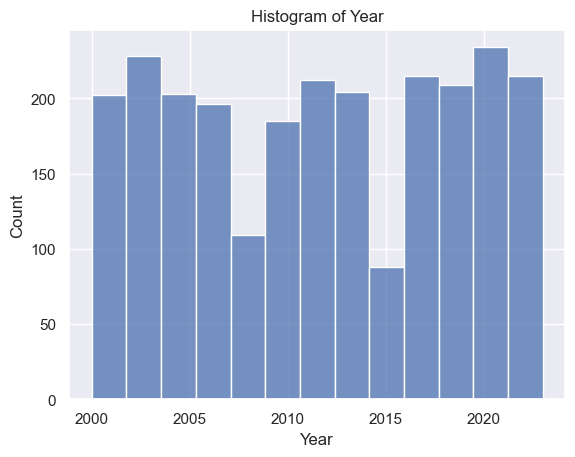

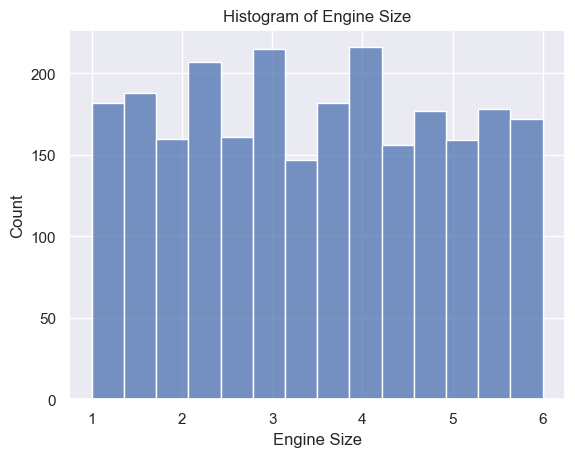

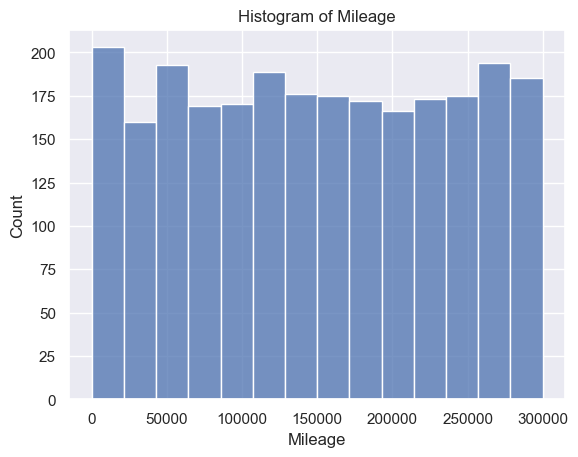

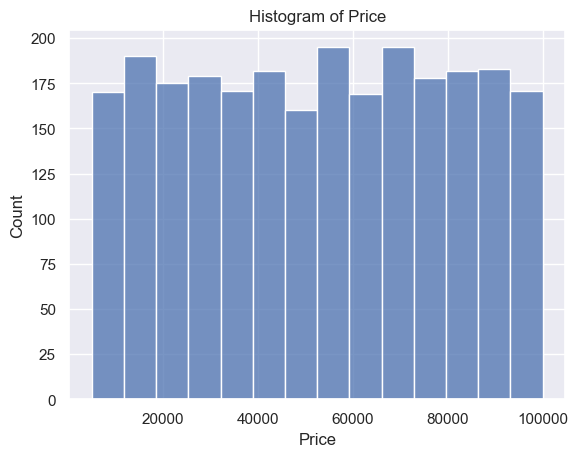

In [64]:
for var in NUMERIC_VARS:
    data = data_df[var]
    fig, ax = plt.subplots()
    sns.histplot(data, ax=ax)
    ax.set_title(f'Histogram of {var}')
    # sns.boxplot(x=data, ax=ax)

## General

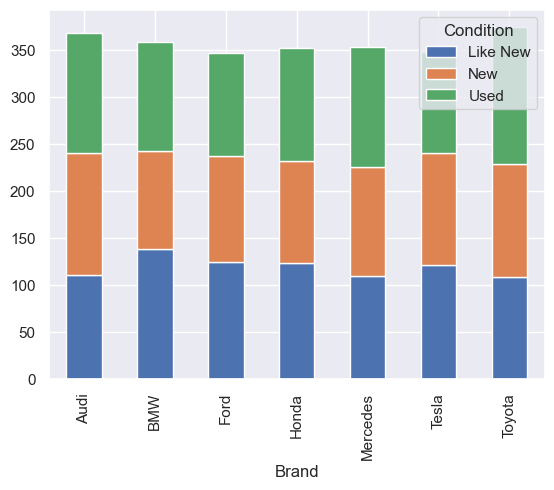

In [65]:
data_df.groupby('Brand')['Condition'].value_counts().unstack().plot(kind='bar', stacked=True);

,Year,Engine Size,Mileage,Price
Year,1.000000,0.011833,0.002282,-0.036805
Engine Size,0.011833,1.000000,-0.015782,-0.004420
Mileage,0.002282,-0.015782,1.000000,-0.008567
Price,-0.036805,-0.004420,-0.008567,1.000000


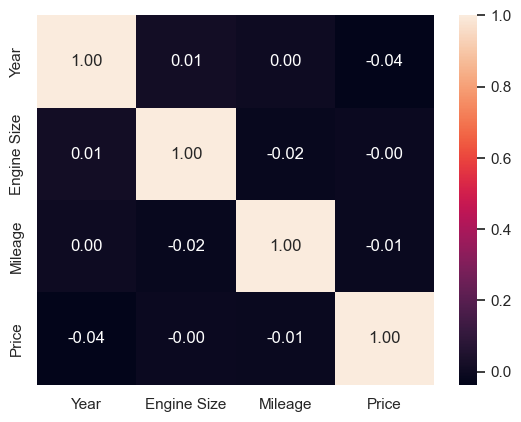

In [66]:
numeric_corr = data_df[NUMERIC_VARS].corr()
sns.heatmap(numeric_corr, annot=True, fmt=".2f")
numeric_corr

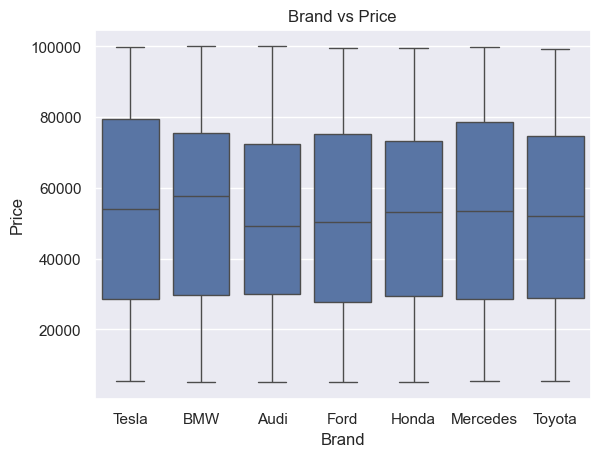

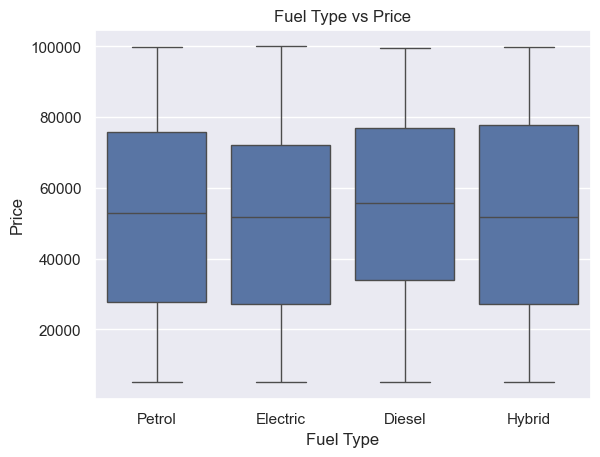

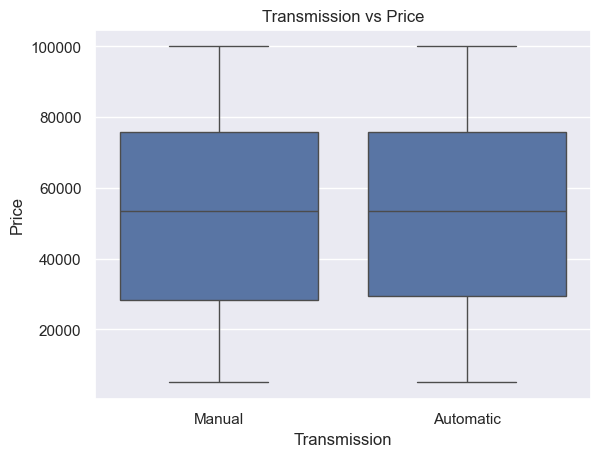

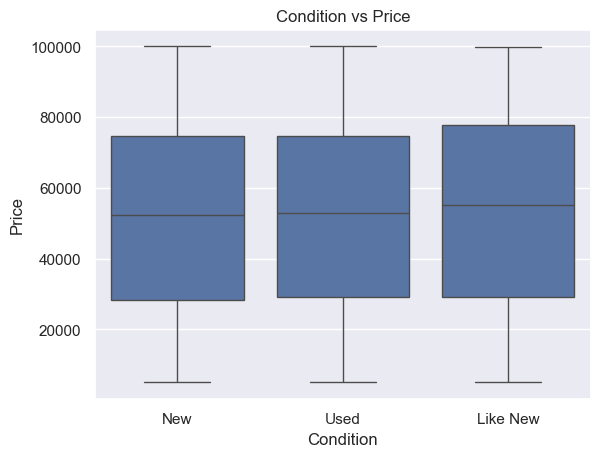

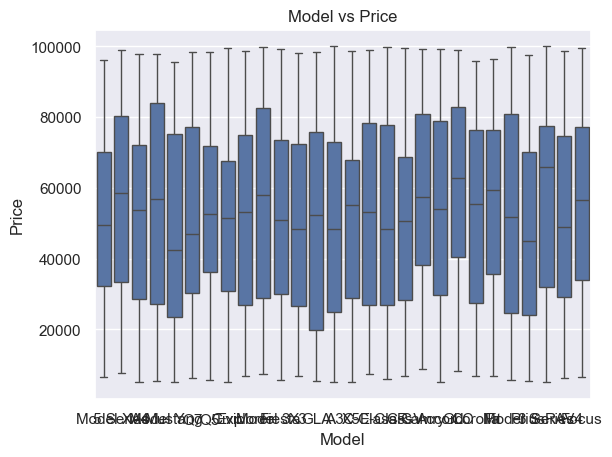

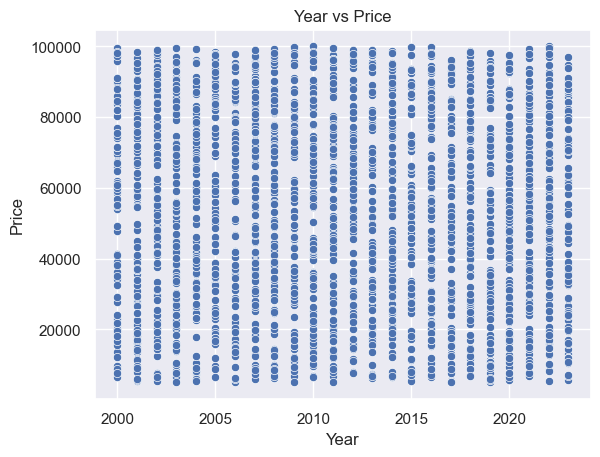

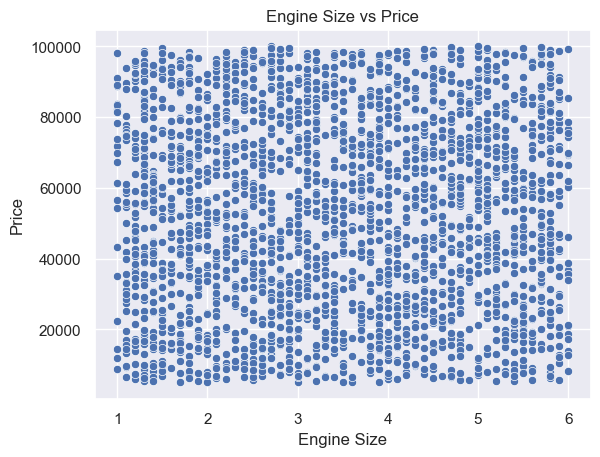

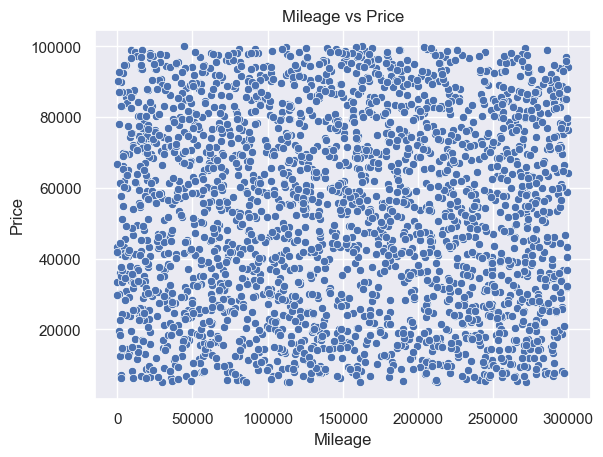

In [67]:
# Plot all variables against my y variable. For categorical variables, use boxplot. For numeric variables, use scatter plot.
for x_var in X_VARS:
    fig, ax = plt.subplots()
    if x_var in CATEGORICAL_VARS:
        sns.boxplot(x=x_var, y=Y_VAR, data=data_df, ax=ax)
    else:
        sns.scatterplot(x=x_var, y=Y_VAR, data=data_df, ax=ax)
    ax.set_title(f'{x_var} vs {Y_VAR}')
    

## Validations

### Missing Values

In [68]:
missing_values = data_df.isnull().sum()
missing_values

Brand           0
Year            0
Engine Size     0
Fuel Type       0
Transmission    0
Mileage         0
Condition       0
Price           0
Model           0
dtype: int64

# Prediction

## Baseline

In [69]:
data_df['Price'].describe().map(lambda x: f'{x:,.2f}')

count     2,500.00
mean     52,638.02
std      27,295.83
min       5,011.27
25%      28,908.49
50%      53,485.24
75%      75,838.53
max      99,982.59
Name: Price, dtype: object

In [70]:
# Set up our baseline model
y = data_df['Price']
price_variance = y.var()
price_std = y.std()
mean_absolute_error = (y - y.mean()).abs().mean()
median_absolute_error = (y - y.median()).abs().mean()
SST = (n-1) * price_variance

# print(f'Price Variance: {price_variance:,.2f}')
print(f'Price Standard Deviation: {price_std:,.2f}')
print(f'Mean Absolute Error: {mean_absolute_error:,.2f}')
print(f'Median Absolute Error: {median_absolute_error:,.2f}')
# print(f'Total Sum of Squares: {SST:,.2f}')

Price Standard Deviation: 27,295.83
Mean Absolute Error: 23,698.95
Median Absolute Error: 23,691.31


## In-Sample Regression

In [71]:
# We need to convert our categorical variables into dummy variables
data_dummy_df = pd.get_dummies(data_df, drop_first=False)

# Convert from boolean to integer
data_dummy_df = data_dummy_df.astype(int)

# Clean up the columns so that there are no spaces
data_dummy_df.columns = data_dummy_df.columns.str.replace(' ', '_')
data_dummy_df

,Year,Engine_Size,Mileage,Price,Brand_Audi,Brand_BMW,Brand_Ford,Brand_Honda,Brand_Mercedes,Brand_Tesla,...,Model_Model_S,Model_Model_X,Model_Model_Y,Model_Mustang,Model_Prius,Model_Q5,Model_Q7,Model_RAV4,Model_X3,Model_X5
Car ID,,,,,,,,,,,,,,,,,,,,,
1,2016,2,114832,26613,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
2,2018,4,143190,14679,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2013,4,181601,44402,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2011,4,68682,86374,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
5,2009,2,223009,73577,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2496,2020,2,22650,61384,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2497,2001,5,77701,24710,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2498,2021,1,272827,29902,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [72]:
# data_dummy_df.columns

### Fit Model

In [73]:
x_vars_dummy = data_dummy_df.columns.tolist()
x_vars_dummy.remove('Price')
x_vars_dummy_clean = [f'Q("{x}")' for x in x_vars_dummy]
formula = f""" Price ~ {' + '.join(x_vars_dummy_clean)} """
formula
ols_model_1 = smf.ols(formula=formula, data=data_dummy_df).fit()


### Results

In [74]:
# Print the RMSE
rmse = np.sqrt(ols_model_1.mse_resid)
print(f'RMSE: {rmse:,.2f}')

RMSE: 27,271.96


In [75]:
print(ols_model_1.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.122
Date:                Sat, 19 Oct 2024   Prob (F-statistic):              0.285
Time:                        09:20:13   Log-Likelihood:                -29063.
No. Observations:                2500   AIC:                         5.820e+04
Df Residuals:                    2463   BIC:                         5.841e+04
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

## Real Data Science

In [76]:
import sklearn
from sklearn.model_selection import train_test_split
rng = np.random.default_rng(42)

## Split Data
If the data is not already bucketed into training, validation, and test. Do that now.

In [77]:
training_set_size = int(n - TEST_SET_PERCENTAGE * n)
print(f'Training set size: {training_set_size}')

Training set size: 2250


In [78]:
def split_data() -> None:

    # Split data into training and testing sets
    train_indexes = rng.choice(range(n), training_set_size, replace=False)
    test_indexes = [i for i in range(n) if i not in train_indexes]

    # Make sure that the sets are disjoint
    assert len(set(train_indexes) & set(test_indexes)) == 0


    train_data = data_df.iloc[train_indexes].copy()
    test_data = data_df.iloc[test_indexes].copy()
    
    return {'training': train_data, 'test': test_data}

if not TRAINING_FILE.exists() or not TEST_FILE.exists() or CREATE_NEW_DATA_SPLITS:
    print(f'No exising files found (Or manual override set to True). Splitting raw data into training, validation, and test sets.')
    data_split = split_data()

    data_split['training'].to_csv(TRAINING_FILE)
    data_split['test'].to_csv(TEST_FILE)



### Load Split Data

In [79]:
training_df = pd.read_csv(TRAINING_FILE, index_col='Car ID')
test_df = pd.read_csv(TEST_FILE, index_col='Car ID')

training_df.shape, test_df.shape

((2250, 9), (250, 9))

In [80]:
training_df.head(2)

,Brand,Year,Engine Size,Fuel Type,Transmission,Mileage,Condition,Price,Model
Car ID,,,,,,,,,
1274,Audi,2014,1.2,Hybrid,Manual,20754,Like New,38371.45,A4
2294,BMW,2020,2.1,Electric,Automatic,190191,New,18957.69,X3


## Evaluation Metrics

## Modeling

* Decision Tree
* Random Forest
* Lasso
* Ridge
* XG Boost

### Decision Tree

In [81]:
# First we need to re-shape our data to make in a format expected by sklearns Decesion Tree Regressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree

In [82]:
X, y = training_df[X_VARS], training_df[Y_VAR]

# Convrert categorical variables into dummy variables
X = pd.get_dummies(X, drop_first=False)

# Convert from boolean to integer for the dummy variables
bool_cols = X.select_dtypes(include=[bool]).columns
X[bool_cols] = X[bool_cols].astype(int)

tree_model = DecisionTreeRegressor(max_depth=10)
tree_model.fit(X, y)

DecisionTreeRegressor(max_depth=10)

In [83]:
# Metrics on the training set
y_pred = tree_model.predict(X)
mse = ((y - y_pred)**2).mean()
rmse = np.sqrt(mse)

# R^2
SSE = ((y - y_pred)**2).sum()
SST_training = ((y - y.mean())**2).sum()
R2 = 1 - SSE / SST_training

print(f'RMSE: {rmse:,.2f}')
print(f'R^2: {R2:.2f}')

RMSE: 23,355.11
R^2: 0.27


#### Grid Search

In [84]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

In [85]:
param_dist =  {
    'max_depth': range(1, 20),
    'min_samples_split': range(2, 20),
    'min_samples_leaf': range(1, 20)
}    

tree_model = DecisionTreeRegressor()
random_search = RandomizedSearchCV(tree_model, param_distributions=param_dist, n_iter=100, cv=5)
random_search.fit(X, y)
print(f"Best parameters: {random_search.best_params_}")

Best parameters: {'min_samples_split': 5, 'min_samples_leaf': 11, 'max_depth': 3}


#### Final Tree 

In [86]:
tree_model = DecisionTreeRegressor(**random_search.best_params_)
tree_model.fit(X, y)

# Metrics on the training set
y_pred = tree_model.predict(X)
mse = ((y - y_pred)**2).mean()
rmse = np.sqrt(mse)

# R^2
SSE = ((y - y_pred)**2).sum()
SST_training = ((y - y.mean())**2).sum()
R2 = 1 - SSE / SST_training

print(f'RMSE: {rmse:,.2f}')
print(f'R^2: {R2:.2f}')

RMSE: 26,997.92
R^2: 0.02


#### Visualize Tree

##### Normal

In [87]:
# fig, ax = plt.subplots(figsize=(20, 8))
# plot_tree(tree_model, feature_names=X.columns, filled=True, ax=ax)
# plt.show()

##### dtreeviz

In [88]:
# import dtreeviz
# viz = dtreeviz.model(tree_model, X, y, target_name='Price', feature_names=X.columns)

# viz.view()
# # save the viz
# viz.save(OUTPUT_FOLDER / 'decision_tree.svg')

## Test Set Evaluation

# The End